# **AI Agent_RAG와 연동**

## **1.환경준비**

### (1) 구글 드라이브

#### 1) 구글 드라이브 폴더 생성
* 새 폴더(LangGraph)를 생성하고
* 제공 받은 파일을 업로드

#### 2) 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### (2) 라이브러리

#### 1) 필요한 라이브러리 설치

In [2]:
!pip install -U "langchain==0.3.*" "langchain-core==0.3.*" "langchain-community==0.3.*" "langchain-openai" "langgraph==0.3.*" "langchain-huggingface" "huggingface_hub" "sentence-transformers" wikipedia -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.2/457.2 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.2/148.2 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 whi

In [ ]:
!pip install -U "langchain==0.3.*" "langchain-core==0.3.*" "langchain-community==0.3.*" "langchain-openai" "langgraph==0.2.*" wikipedia -q

In [3]:
!pip install chromadb google-search-results -q

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

#### 2) 라이브러리 로딩

In [4]:
import pandas as pd
import numpy as np
import os
import openai

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.graph import END, START, StateGraph, MessagesState
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langchain.chains import RetrievalQA
from langchain_community.vectorstores import Chroma
from langchain.agents import load_tools
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

### (3) OpenAI API Key 확인

In [20]:
def load_api_keys(filepath="api_key.txt"):
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if line and "=" in line:
                key, value = line.split("=", 1)
                os.environ[key.strip()] = value.strip()

path = '/content/drive/MyDrive/LangGraph/'

# API 키 로드 및 환경변수 설정
load_api_keys(path + 'api_key.txt')

⚠️ 아래 코드셀은, 실행해서 key가 제대로 보이는지 확인하고 삭제하세요.

In [ ]:
print(os.environ['HUGGINGFACEHUB_API_TOKEN'][:30])

## 2.RAG 기반 Agent 구축하기
* 사용자 요청사항 내용을 보고 RAG 혹은 구글 검색을 통해 답변하는 챗봇 만들기
* 이미 제공된 sample.csv를 기반으로 벡터DB 구축
* 도구 준비
    * 벡터 DB 를 tool로 구성
    * 구글 검색도구 구성
    * 툴 리스트
* Agent 만들기

### (1) Vector DB 준비

In [39]:
from langchain_huggingface import HuggingFaceEmbeddings # OpenAI 대신 사용
from langchain.vectorstores import Chroma
from langchain.document_loaders import CSVLoader

# CSV 파일 로드
csv_path = "sample.csv"
csv_loader = CSVLoader(file_path= path + csv_path)
documents_csv = csv_loader.load()
# Hugging Face 임베딩 모델
embedding = HuggingFaceEmbeddings(model_name="jhgan/ko-sroberta-multitask")

vector_db = Chroma.from_documents(documents_csv, embedding,
                                    persist_directory= path + "chroma_db")
retriever = vector_db.as_retriever(search_kwargs={"k": 3})
print("ChromaDB에 저장 완료!")

ChromaDB에 저장 완료!


### (2) Tool 정의

In [40]:
@tool
def vectordb_search(query: str) -> str:
    """내장 문서로부터 관련 정보를 검색합니다."""  # docstring 꼭 포함되어야 함!
    # 유사도 기준으로 상위 k개 문서를 벡터스토어에서 검색
    docs = retriever.get_relevant_documents(query)

    # 검색된 문서 내용들을 줄바꿈으로 구분하여 하나의 문자열로 반환
    return "\n\n".join(d.page_content for d in docs)

# tool 리스트
tools = [vectordb_search]

# 툴 실행 노드 (LangGraph 제공)
tool_node = ToolNode(tools)



In [41]:
# 구글 검색도구 구성 : SerpAPI
tools_web = load_tools(["serpapi"])  # langchain 내장 도구
web_search_tool = tools_web[0]  # serpapi tool 객체

In [42]:
# 툴 리스트
tools = [vectordb_search, web_search_tool]

### (3) LLM+Tool 바인딩

In [43]:
tool_node = ToolNode(tools)
hf_ep = HuggingFaceEndpoint(repo_id="openai/gpt-oss-20b", task="conversational")
llm = ChatHuggingFace(llm=hf_ep).bind_tools(tools)

### (4) 노드 준비 & 분기 함수

In [44]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [45]:
# GPT 호출 노드
def call_model(state: State):
    messages = state["messages"]
    response = llm.invoke(messages)

    # SQLite 저장 시 발생하는 직렬화 에러 방지 (HuggingFace 특화)
    if hasattr(response, "additional_kwargs"):
        response.additional_kwargs = {}

    return {"messages": [response]}

# 툴 사용 여부 판단
def should_continue(state: State) -> Literal["tools", END]:
    last = state["messages"][-1]            # 대화의 가장 마지막 객체(가장 최근 대화)
    # if getattr(last, "tool_calls", None):   # last에서 tool_calls 내용이 포함되면, 'tool_calls', 아니면 None
    #     return "tools"
    if hasattr(last, "tool_calls") and last.tool_calls:
        return "tools"
    return END

### (5) 그래프 구성

In [46]:
builder = StateGraph(State)
builder.add_node("call_model", call_model)
builder.add_node("tools", tool_node)

# connect nodes
builder.add_edge(START, "call_model")
builder.add_conditional_edges("call_model", should_continue)
builder.add_edge("tools", "call_model")

graph = builder.compile()

* 그래프 시각화

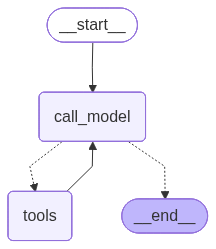

In [47]:
graph

### (6) 실행

In [49]:
result = graph.invoke({"messages": [HumanMessage(content="sample.csv에 적힌 주요 보안 위협이 뭐야? 그리고 최신 뉴스에서는 어떤 보안 사고가 있었어?")]})

for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

sample.csv에 적힌 주요 보안 위협이 뭐야? 그리고 최신 뉴스에서는 어떤 보안 사고가 있었어?
================================== Ai Message ==================================
Tool Calls:
  Search (fc_b95369ff-1bed-46c5-9094-91fc1d41b8dc)
 Call ID: fc_b95369ff-1bed-46c5-9094-91fc1d41b8dc
  Args:
    __arg1: latest security incidents 2026
================================= Tool Message =================================
Name: Search

['In this blog are some of the most impactful and widely reported cyber attacks of 2025 and the lessons they carry forward.', 'In 2026, there will be more attacks utilizing realistic voice cloning and high-quality video deepfakes, says Joshua Walsh, information security ...', 'Cybersecurity experts discuss 2026 predictions, highlighting the rise of AI-driven threats, the shift to resilience over prevention, and the ...', 'Discover the biggest cybersecurity threats in 2026 – from ransomware and AI scams to IoT hacks 